Training conditional VAE on torque level with DMP

In [1]:
import os, time, tqdm, sys
import numpy as np
import torch

# add parent directory to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from models.dmp import CanonicalSystem, SingleDMP
from models.vae import DmpCVAE, DM
from torch.utils.data import DataLoader
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop
from matplotlib import pyplot as plt
print(os.getcwd())

/home/binzhao/Documents/code/VAE_DMP_mani/manipulation_task


In [2]:
# create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

run_time = 1
dt = 0.01
# define the shape of each damonstration
shape = (5, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)
print("device: ", device)   

device:  cuda


Load the data and normalize the data

In [3]:
train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=5)
test_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=5)
train_dataset.load_data('../data/manipulation_data/train_torque.npz', device=device)
# test_dataset.load_data('../data/number_write/test_torque.npz', device=device)

train_dataset.torque = train_dataset.normalize_data(device=device)
# test_dataset.torque = test_dataset.normalize_data(device=device)

print("train dataset size: ", len(train_dataset))
# print("test dataset size: ", len(test_dataset))

train dataset size:  30000


In [4]:
# create dataloader for training and testing
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_iter = DataLoader(test_dataset, batch_size=64, shuffle=True)
vae_net = DmpCVAE(dmp=dmp, shape=shape, nclass=4, nhid=8, ncond=8)
vae_net.to(device)

DmpCVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv1d(5, 16, kernel_size=(5,), stride=(2,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
      (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
      (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
        (mlp): Se

/home/binzhao/Documents/code/VAE_DMP_mani/utils/data_loader.py:220: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return torque.T, label.T


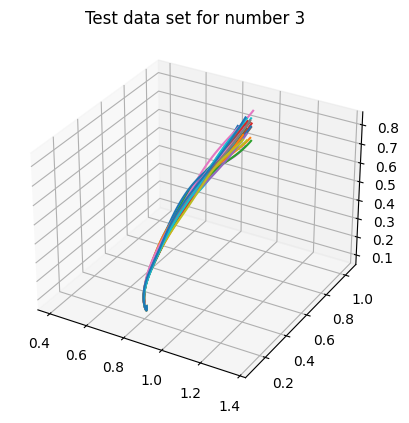

In [5]:
number = 3

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = 0
for x, y in train_iter:
    # get index of y equal to number
    index = torch.where(y[:, 0] == number)[0]
    
    # plot 3D trajectory with different color
    for i in range(len(index)):
        ax.plot(x[index[i], 0, :].cpu().numpy().T, x[index[i], 1, :].cpu().numpy().T, x[index[i], 2, :].cpu().numpy().T)
    break
# add axis label
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.title("Test data set for number " + str(number))
plt.axis('equal')
plt.show()

In [6]:
# %% train model
lr = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vae_net.parameters()), lr=lr, weight_decay=0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

Define the early stop function, load the function

In [7]:
# %% if load
save_name = "cVAE_torque_manipulation.pt"
retrain = True
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location=device)
        vae_net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for g in optimizer.param_groups:
            g['lr'] = lr

early_stop = EarlyStop(patience=10, save_name=save_name)

Training the network

training on  cuda


100%|██████████| 469/469 [00:01<00:00, 292.06it/s]


epoch:  0
train loss:  0.03029514197446406
time:  1.608717918395996


100%|██████████| 469/469 [00:01<00:00, 366.91it/s]


epoch:  10
train loss:  3.791432660073042e-05
time:  1.2797825336456299


100%|██████████| 469/469 [00:01<00:00, 358.56it/s]


epoch:  20
train loss:  1.3222437466417129e-05
time:  1.309342384338379


100%|██████████| 469/469 [00:01<00:00, 337.86it/s]


epoch:  30
train loss:  9.272026062050523e-06
time:  1.3893609046936035


100%|██████████| 469/469 [00:01<00:00, 361.72it/s]


epoch:  40
train loss:  7.748382080656787e-06
time:  1.297722339630127


100%|██████████| 469/469 [00:01<00:00, 362.93it/s]


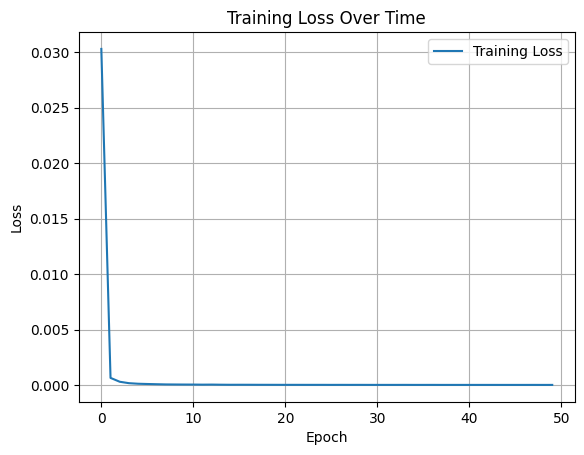

In [8]:
max_epochs = 50

plt.ion()
print("training on ", device)
losses = []
for epoch in range(max_epochs):
    vae_net.train()
    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm.tqdm(train_iter, ncols=50):
        X = X.to(device)
        # only use the first dimension of y
        y = y[:, 0].to(device)
        X_hat, mean, logvar = vae_net(X, y)

        l = vae_net.loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n

    if epoch %10 == 0:
        print("epoch: ", epoch)
        print("train loss: ", train_loss)
        print("time: ", time.time() - start)
        early_stop(train_loss, vae_net, optimizer)
        if early_stop.early_stop:
            print("Early stopping")
            break  
        
    # ------------ plot the train loss ----------------
    losses.append(train_loss)

plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()
   
    


Generate trajectory from the torque

In [10]:
# obtain the initial position and goal position from the dataset
# load train path data set
from utils.data_loader import ManipulationLoader
traj_loader = ManipulationLoader(run_time=1.0, dmp=dmp, dt=0.01, dof=5)
traj_loader.load_data("../data/manipulation_data/train_paths.npz")

# get one trajectory
# generate a random int 
index = np.random.randint(0, len(traj_loader.paths))
traj = traj_loader.paths[index]
label = traj_loader.labels[index]

# get the initial position and goal position
task_id = label[0]
init_pos = traj[0]
goal_pos = traj[-1]
print("task id: ", task_id)
print("init pos: ", init_pos)
print("goal pos: ", goal_pos)

task id:  3.0
init pos:  [ 0.69140726  0.16487871  0.63714111 -0.01653005  0.9999789 ]
goal pos:  [ 0.63186771 -0.09722069  0.22036721 -0.0784045   0.53770471]


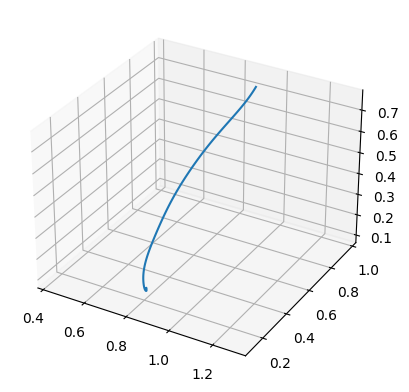

In [15]:
vae_net.eval()
number = int(task_id)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot 3D force
for i in range(1):
    with torch.no_grad():
        torque = vae_net.generate(number)    
    # plot the generated force
    ax.plot(torque[0, 0, :].cpu().numpy().T, torque[0, 1, :].cpu().numpy().T, torque[0, 2, :].cpu().numpy().T)    
plt.axis("equal")
plt.show() 


denormalize the data

torch.Size([1, 5, 100])


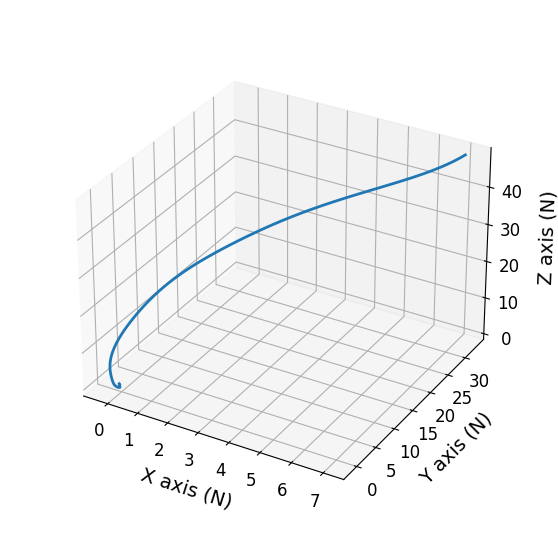

In [16]:
real_torque = train_dataset.denormalize_data(torque)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
print(real_torque.shape)
ax.plot(real_torque[0, 0, :].cpu().numpy().T, real_torque[0, 1, :].cpu().numpy().T, real_torque[0, 2, :].cpu().numpy().T, linewidth=2)    
ax.set_xlabel('X axis (N)', fontsize=14, labelpad=10)
ax.set_ylabel('Y axis (N)', fontsize=14, labelpad=10)
ax.set_zlabel('Z axis (N)', fontsize=14, labelpad=10) 
ax.set_box_aspect(aspect=None, zoom=0.86)

ax.tick_params(axis='x', labelsize=12)  # Set font size for x-axis ticks
ax.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks
ax.tick_params(axis='z', labelsize=12)  # Set font size for z-axis ticks


plt.show()

Generate trajectory by DM system

In [17]:
#real_torque = torch.zeros((1, 5, 100)).to(device)
real_torque = real_torque[0]
dmp_traj = vae_net.get_trajectory(real_torque, init_pos, goal_pos)


(100, 5)
(1, 5, 100)
end of trajectory:  [[ 0.63138884 -0.09662319  0.22477931 -0.07499015  0.55336136]]


Text(0, 0.5, 'Gripper state')

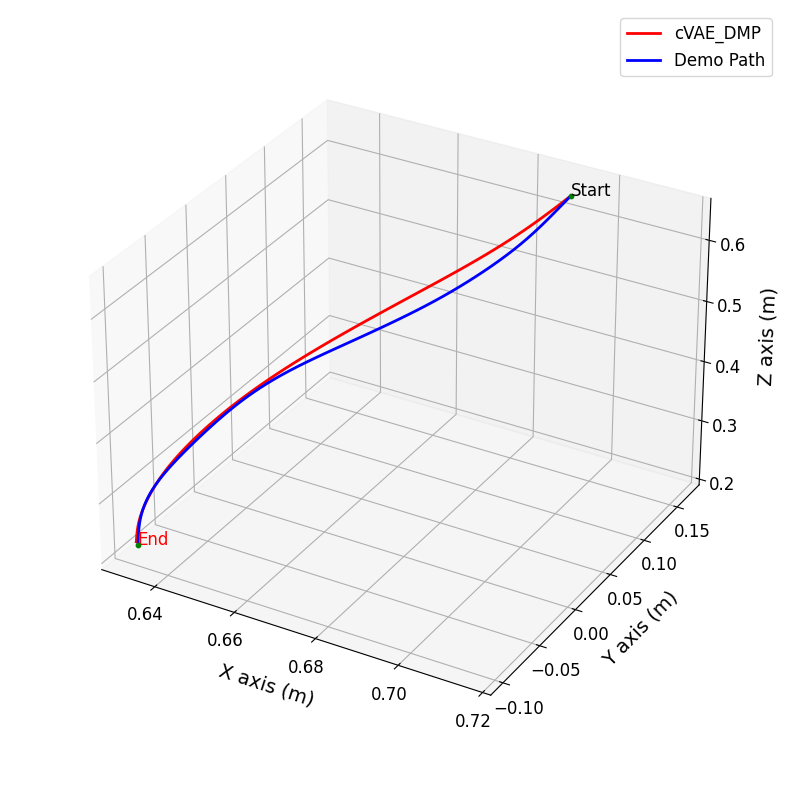

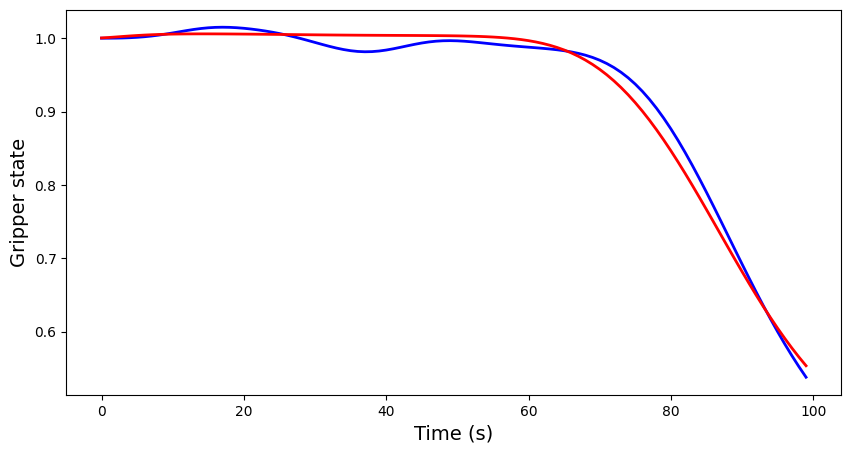

In [19]:
# plot the real trajectory
print(traj.shape)
print(dmp_traj.shape)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(dmp_traj[:, 0, :].T, dmp_traj[:, 1, :].T, dmp_traj[:, 2, :].T, color='red', linewidth=2)
ax.plot(traj[:, 0].T, traj[:, 1].T, traj[:, 2].T, color='blue', linewidth=2)

print("end of trajectory: ", dmp_traj[:, :, -1])

# add marks for the initial and goal position
ax.scatter(init_pos[0], init_pos[1], init_pos[2], color='green', s=10)
ax.scatter(goal_pos[0], goal_pos[1], goal_pos[2], color='green', s=10)

# Customize labels with font size
ax.set_xlabel('X axis (m)', fontsize=14, labelpad=10)
ax.set_ylabel('Y axis (m)', fontsize=14, labelpad=10)
ax.set_zlabel('Z axis (m)', fontsize=14, labelpad=10)

# Optionally, set tick parameters to adjust tick labels' font size
x_ticks = np.arange(0.64, 0.74, 0.02)
plt.xticks(x_ticks)
ax.tick_params(axis='x', labelsize=12)  # Set font size for x-axis ticks
ax.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks
ax.tick_params(axis='z', labelsize=12)  # Set font size for z-axis ticks

# Customize labels with font size
ax.set_xlabel('X axis (m)', fontsize=14, labelpad=10)
ax.set_ylabel('Y axis (m)', fontsize=14, labelpad=10)
ax.set_zlabel('Z axis (m)', fontsize=14, labelpad=10)

ax.text(*init_pos[0:3], 'Start', color='black', fontsize=12)
ax.text(*goal_pos[:3], 'End', color='red', fontsize=12)

# add legend
ax.legend(['cVAE_DMP', 'Demo Path'], loc='upper right', fontsize=12)

ax.set_box_aspect(aspect=None, zoom=0.9)

# plot the gripper state in original trajectory and dmp trajectory
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(traj[:, 4].T, color='blue', linewidth=2)
ax.plot(dmp_traj[:, 4].T, color='red', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('Gripper state', fontsize=14)



In [18]:
# generate error 
error = np.linalg.norm(dmp_traj[:, :3, -1] - goal_pos[0:3])
print("error: ", error)

error:  0.0037998930538013244
